# PIC-SURE API tutorial using CureSC database

This is a tutorial notebook, aimed for the user to be quickly up and running with the python PIC-SURE API. It covers the main functionalities of the API.

## PIC-SURE python API 
### What is PIC-SURE? 

<!--img src="./img/PIC-SURE_logo.png" width= "360px"> -->

Databases exposed through PIC-SURE API encompass a wide heterogeneity of architectures and data organizations underneath. PIC-SURE hide this complexity and expose the different databases in the same format, allowing researchers to focus on the analysis and medical insights, thus easing the process of reproducible sciences.

### More about PIC-SURE
PIC-SURE stands for Patient-centered Information Commons: Standardized Unification of Research Elements. The API is available in two different programming languages, python and R, allowing investigators to query databases in the same way using any of those languages.

PIC-SURE is a large project from which the R/python PIC-SURE API is only a brick. Among other things, PIC-SURE also offers a graphical user interface, allowing research scientist to get quick knowledge about variables and data available for a specific data source.

The python API is actively developed by the Avillach-Lab at Harvard Medical School.

GitHub repo:
* https://github.com/hms-dbmi/pic-sure-python-adapter-hpds
* https://github.com/hms-dbmi/pic-sure-python-client



 -------   

# Getting your own user-specific security token

**Before running this notebook, please be sure to review the get_your_token.ipynb notebook. It contains explanation about how to get a security token, mandatory to access the databases.**

# Environment set-up

### Pre-requisite
- python 3.6 or later (although earlier versions of Python 3 must work too)
- pip: python package manager, already available in most system with a python interpreter installed ([pip installation instructions](https://pip.pypa.io/en/stable/installing/))

### IPython magic command

Those two lines of code below do load the `autoreload` IPython extension. Although not necessary to execute the rest of the Notebook, it does enable to reload every dependency each time python code is executed, thus enabling to take into account changes in external file imported into this Notebook (e.g. user defined function stored in separate file), without having to manually reload libraries. Turns out very handy when developing interactively. More about [IPython Magic commands](https://ipython.readthedocs.io/en/stable/interactive/magics.html).

In [1]:
%load_ext autoreload
%autoreload 2

### Installation of required python packages

Using the pip package manager, we install the packages listed in the `requirements.txt` file.

In [2]:
!cat requirements.txt

numpy>=1.17.3
matplotlib>=3.1.1
pandas>=0.25.3
scipy>=1.3.1
tqdm>=4.38.0
statsmodels>=0.10.2
git+https://github.com/hms-dbmi/pic-sure-python-adapter-hpds.git
git+https://github.com/hms-dbmi/pic-sure-python-client.git 


In [3]:
import sys
!{sys.executable} -m pip install -r requirements.txt

  Cloning https://github.com/hms-dbmi/pic-sure-python-adapter-hpds.git to /private/var/folders/hm/wn0bpy0j7vl2q9gqnhhccpph0000gn/T/pip-req-build-jqshh2x_
  Running command git clone -q https://github.com/hms-dbmi/pic-sure-python-adapter-hpds.git /private/var/folders/hm/wn0bpy0j7vl2q9gqnhhccpph0000gn/T/pip-req-build-jqshh2x_
  Cloning https://github.com/hms-dbmi/pic-sure-python-client.git to /private/var/folders/hm/wn0bpy0j7vl2q9gqnhhccpph0000gn/T/pip-req-build-vcvoejo7
  Running command git clone -q https://github.com/hms-dbmi/pic-sure-python-client.git /private/var/folders/hm/wn0bpy0j7vl2q9gqnhhccpph0000gn/T/pip-req-build-vcvoejo7
  Created wheel for PicSureHpdsLib: filename=PicSureHpdsLib-0.9.0-py2.py3-none-any.whl size=17755 sha256=575926a4145ecdc999f93266fd61c60f44c2bbf80d4e581f4d87dbde98840ca9
  Stored in directory: /private/var/folders/hm/wn0bpy0j7vl2q9gqnhhccpph0000gn/T/pip-ephem-wheel-cache-73ed44el/wheels/6c/ac/12/4d142709d83e0bdd96c661e183f2dcbb0e03f90e98e5ac256e
  Created wh

Import all the external dependencies, as well as user-defined functions stored in the `python_lib` folder

In [4]:
import json
from pprint import pprint

import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from scipy import stats

import PicSureHpdsLib
import PicSureClient

from python_lib.utils import get_multiIndex_variablesDict, get_dic_renaming_vars, joining_variablesDict_onCol

In [5]:
print("NB: This Jupyter Notebook has been written using PIC-SURE API following versions:\n- PicSureClient: 0.1.0\n- PicSureHpdsLib: 1.1.0\n")
print("The PIC-SURE API libraries versions you've been downloading are: \n- PicSureClient: {0}\n- PicSureHpdsLib: {1}".format(PicSureClient.__version__, PicSureHpdsLib.__version__))

NB: This Jupyter Notebook has been written using PIC-SURE API following versions:
- PicSureClient: 0.1.0
- PicSureHpdsLib: 1.1.0

The PIC-SURE API libraries versions you've been downloading are: 
- PicSureClient: 1.1.0
- PicSureHpdsLib: 1.1.0


##### Set up the options for displaying tables and plots in this Notebook

In [6]:
# Pandas DataFrame display options
pd.set_option("max.rows", 100)

# Matplotlib parameters options
fig_size = plt.rcParams["figure.figsize"]
 
# Prints: [8.0, 6.0]
fig_size[0] = 14
fig_size[1] = 8
plt.rcParams["figure.figsize"] = fig_size

font = {'weight' : 'bold',
        'size'   : 14}

plt.rc('font', **font)

### Connecting to a PIC-SURE network

Several information are needed to get access to data through the PIC-SURE API: a network URL, a resource id, and a user security token which is specific to a given URL + resource.

In [7]:
PICSURE_network_URL = "https://curesc.hms.harvard.edu/picsure"
resource_id = "37663534-6161-3830-6264-323031316539"
token_file = "token.txt"

In [8]:
with open(token_file, "r") as f:
    my_token = f.read()

In [9]:
client = PicSureClient.Client()
connection = client.connect(PICSURE_network_URL, my_token)
adapter = PicSureHpdsLib.Adapter(connection)
resource = adapter.useResource(resource_id)

Two objects are created here: a `connection` and a `resource` object, using respectively the `picsure` and `hpds` libraries. 

As we will only be using one single resource, **the `resource` object is actually the only one we will need to proceed with data analysis hereafter** (FYI, the `connection` object is useful to get access to different databases stored in different resources). 

It is connected to the specific data source ID we specified, and enables to query and retrieve data from this source.

### Getting help with the PIC-SURE python API

Each object exposed by the PicSureHpdsLib library got a `help()` method. Calling it will print out a helper message about it. 

In [10]:
resource.help()


        [HELP] PicSureHpdsLib.useResource(resource_uuid)
            .dictionary()       Used to access data dictionary of the resource
            .query()            Used to query against data in the resource
            
        [ENVIRONMENT]
              Endpoint URL: https://curesc.hms.harvard.edu/picsure/
             Resource UUID: 37663534-6161-3830-6264-323031316539


For instance, this output tells us that this `resource` object got 2 methods, and it gives insights about their function. 

## Using the *variables dictionnary*

Once connection to the desired resource has been established, we first need to get a quick grasp of which variables are available in the database. To this end, we will use the `dictionary` method of the `resource` object.

A `dictionary` instance offers the possibility to retrieve matching records according to a specific term, or to retrieve information about all available variables, using the `find()` method. For instance, looking for variables containing the term `Stroke` is done this way: 

Objects created by the `dictionary.find` exposes the search result using 4 different methods: `.count()`, `.keys()`, `.entries()`, and `.DataFrame()`. 

In [11]:
dictionary = resource.dictionary()
dictionary_search = dictionary.find("Smoke")
dictionary_search.DataFrame().head()

,categorical,categoryValues,observationCount,patientCount,HpdsDataType,min,max
KEY,,,,,,,
"\SAC\semtel\18. Do you live with anyone who currently smokes cigarettes? (not only the place where you live most of the time, but any other place where you also spend the night on a regular basis ie. Grandparents' house, mom's house or dad's house, etc.)\",True,"[No, Yes]",66,66,phenotypes,NaN,NaN
"\SAC\interimhx\40. Does the participant LIVE with anyone who currently smokes cigarettes? (not only the place where you live most of the time, but any other place where you also spend the night on a regular basis i.e. Grandparents' house, mom's house or dad's house, etc.)\",True,"[No, Yes]",242,224,phenotypes,NaN,NaN
\SAC\semtel\23. Have you been around anyone who smokes in the past week?\,True,"[No, Yes]",66,66,phenotypes,NaN,NaN
\SAC\semtel\25. Have you been around anyone who smokes in the past 24 hours?\,True,"[No, Yes]",66,66,phenotypes,NaN,NaN
"\SAC\ih_form\27. Since the last visit date, has the participant been exposed to second hand tobacco, cigarette, pipe or cigar smoke?\",True,"[No, Yes]",334,253,phenotypes,NaN,NaN


**`.DataFrame()` enables to get the result of the dictionary search in a pandas DataFrame format** 

The dictionary provide various information about the variables, such as:
- observationCount: number of entries with non-null value
- categorical: type of the variables, True if categorical, False if continuous/numerical
- min/max: only provided for non-categorical variables
- HpdsDataType: 'phenotypes' or 'genotypes'. Currently, the API only expsoses'phenotypes' variables

Hence, it enables to:
* Use the various variables information as criteria for variable selection.
* Use the row names of the DataFrame to get the actual variables names, to be used in the query, as shown below.


In [12]:
pprint({"Count": dictionary_search.count(), 
        "Keys": dictionary_search.keys()[0:3],
        "Entries": dictionary_search.entries()[0:3]})

{'Count': 37,
 'Entries': [{'HpdsDataType': 'phenotypes',
              'categorical': True,
              'categoryValues': ['No', 'Yes'],
              'name': '\\SAC\\semtel\\18. Do you live with anyone who '
                      'currently smokes cigarettes? (not only the place where '
                      'you live most of the time, but any other place where '
                      'you also spend the night on a regular basis ie. '
                      "Grandparents' house, mom's house or dad's house, "
                      'etc.)\\',
              'observationCount': 66,
              'patientCount': 66},
             {'HpdsDataType': 'phenotypes',
              'categorical': True,
              'categoryValues': ['No', 'Yes'],
              'name': '\\SAC\\interimhx\\40. Does the participant LIVE with '
                      'anyone who currently smokes cigarettes? (not only the '
                      'place where you live most of the time, but any other '
                

Variable names, as currently implemented in the API, are long and got backslashes that prevent from using copy-pasting to directly select a variable name. 

However, using the dictionary to select variables can help to deal with this. Hence, one way to proceed is to retrieve the whole dictionary in the form of a pandas DataFrame, as below:

In [13]:
plain_variablesDict = resource.dictionary().find().DataFrame()

Indeed, using the `dictionary.find()` function without arguments return every entries, as shown in the help documentation.

In [14]:
resource.dictionary().help()


        [HELP] PicSureHpdsLib.Client(connection).useResource(uuid).dictionary()
            .find()                 Lists all data dictionary entries
            .find(search_string)    Lists matching data dictionary entries
        


In [15]:
plain_variablesDict.iloc[10:20,:]

,categorical,categoryValues,observationCount,patientCount,HpdsDataType,min,max
KEY,,,,,,,
\SIT - Cure Sickle Cell\04 - Arm 3: Observation: Non-Transfusion\M16\S18r1 Hematology And Physical Exam (s18r1_hematology_and_physical_exam)\3. GU: dysuria discharge\,True,[Normal],4,4,phenotypes,NaN,NaN
\SIT - Cure Sickle Cell\04 - Arm 3: Observation: Non-Transfusion\M36 (Q12) Annual 3: END\S53r0 Transmittal Of Proteomics Samples (s53r0_transmittal_of_proteomics_samples)\3A. How many labels did you attach to this form? (xx)\,False,None,50,50,phenotypes,0.0,12.0
\SIT - Cure Sickle Cell\03 - Arm 2: Transfusion #31 & Int\T32\S31r4 Transfusion Form (s31r4_transfusion_form)\3D. AST\,True,"[Done, Not Done]",33,33,phenotypes,NaN,NaN
\SIT - Cure Sickle Cell\01 - Arm 4: Screening\02 - Re-screening 1\S02r1 Demographic And Phenotypic Information (s02r1_demographic_and_phenotypic_information)\53D1. If Other specify:\,True,"[TYLENOL WITH CODEINE 1 1/2 TSP, VITAMIN C]",2,2,phenotypes,NaN,NaN
\SIT - Cure Sickle Cell\02 - Arm 1: Treatment: Transfusion\M36 (Q12) Annual 3: END\S10r1 Neurological Consultant Report (s10r1_neurological_consultant_report)\30B7. Pinprick - Left face\,True,"[NE, Normal]",87,87,phenotypes,NaN,NaN
\SIT - Cure Sickle Cell\04 - Arm 3: Observation: Non-Transfusion\M33 (Q11)\S18r1 Hematology And Physical Exam (s18r1_hematology_and_physical_exam)\16. Drug allergies:\,True,"[None known, Yes]",66,66,phenotypes,NaN,NaN
"\SAC\ih_form\6. In the past MONTH, how often has the participant had cough, wheeze, shortness of breath, or chest tightness while exercising or playing?\",True,"[10 or more times per month, 2 or fewer times ...",372,253,phenotypes,NaN,NaN
\SIT - Cure Sickle Cell\02 - Arm 1: Treatment: Transfusion\M36 (Q12) Annual 3: END\S10r1 Neurological Consultant Report (s10r1_neurological_consultant_report)\29G. Describe any abnormalities with coordination:\,True,"[L hip surgery limits exam of LLE, N/A, UNABLE...",10,10,phenotypes,NaN,NaN
\SIT - Cure Sickle Cell\04 - Arm 3: Observation: Non-Transfusion\M02\S18r1 Hematology And Physical Exam (s18r1_hematology_and_physical_exam)\18. Hydroxyurea:\,True,[No],1,1,phenotypes,NaN,NaN


#### Variable dictionary + pandas multiIndex

Though helpful, we can use a simple user-defined function (`get_multiIndex_variablesDict`) to add a little more information and ease dealing with variables names. It takes advantage of pandas MultiIndex functionality [see pandas official documentation on this topic](https://pandas.pydata.org/pandas-docs/stable/user_guide/advanced.html).

Although not an official feature of the API, such functionality illustrate how to quickly scan an select groups of related variables.

Printing the 'multiIndexed' variable Dictionary allows to quickly see the tree-like organisation of the variables. Moreover, original and simplified variable names are now stored respectively in the "name" and "simplified_name" columns.

In [16]:
variablesDict = get_multiIndex_variablesDict(plain_variablesDict)

In [17]:
variablesDict.loc[["SIT - Cure Sickle Cell"],:]

simplified_name  \
level_0                level_1                                  level_2                 level_3                                            level_4                                            level_5                                            level_6 level_7 level_8                                                      
SIT - Cure Sickle Cell 00 - Demographics                        Age at inclusion        NaN                                                NaN                                                NaN                                                NaN     NaN     NaN                                       Age at inclusion   
                                                                Gender                  NaN                                                NaN                                                NaN                                                NaN     NaN     NaN                                                 Gender   
                       01 - Arm 4: Screening                    01 - Screening          00 -Consent                                        S01r0 Consent and Assent for Screening (s01r0_c... 2. The patient has given assent for screening. ... NaN     NaN     NaN      2. The patient has given assent for screening....   
                                                                                                                                           S12r0 Consent And Assent For Randomization (s12... 1. The legally authorized representative of the... NaN     NaN     NaN      1. The legally authorized representative of th...   
                                                                                                                                                                                              2. The patient has given assent for randomizati... NaN     NaN     NaN      2. The patient has given assent for randomizat...   
...                                                                                                                                                                                                                                                                                                                     ...   
                       04 - Arm 3: Observation: Non-Transfusion M36 (Q12) Annual 3: END S57r0 Site Exit Summary Worksheet (s57r0_site_e... If not done  explain why: (repeated path 7)        NaN                                                NaN     NaN     NaN            If not done  explain why: (repeated path 7)   
                                                                                                                                           If not done  explain why: (repeated path 8)        NaN                                                NaN     NaN     NaN            If not done  explain why: (repeated path 8)   
                                                                                                                                           If not done  explain why: (repeated path 9)        NaN                                                NaN     NaN     NaN            If not done  explain why: (repeated path 9)   
                                                                                                                                           If not done  explain why:                          NaN                                                NaN     NaN     NaN                              If not done  explain why:   
                                                                                                                                           Select type of study exit:                         NaN                                                NaN     NaN     NaN                             Select type of study exit:   

                                                                                                                                                        

In [18]:
# We limit the number of lines to be displayed for the future outputs
pd.set_option("max.rows", 50)

Below is a simple example to illustrate the ease of use a multiIndex dictionary. Let's say we are interested in every variables pertaining to the "Transplant related" of the "CIBMTR" study.

In [19]:
mask_study = variablesDict.index.get_level_values(0) == "CIBMTR - Cure Sickle Cell Disease"
mask_transplant = variablesDict.index.get_level_values(1) == "3 - Transplant related"
transplant_variables = variablesDict.loc[mask_study & mask_transplant,:]
transplant_variables

simplified_name  \
level_0                           level_1                level_2                                            level_3 level_4 level_5 level_6 level_7 level_8                                                      
CIBMTR - Cure Sickle Cell Disease 3 - Transplant related ATG/Alemtuzumab given as conditioning regimen/G... NaN     NaN     NaN     NaN     NaN     NaN      ATG/Alemtuzumab given as conditioning regimen/...   
                                                         Conditioning intensity                             NaN     NaN     NaN     NaN     NaN     NaN                                 Conditioning intensity   
                                                         Conditioning regimen                               NaN     NaN     NaN     NaN     NaN     NaN                                   Conditioning regimen   
                                                         Donor type                                         NaN     NaN     NaN     NaN     NaN     NaN                                             Donor type   
                                                         Donor-recipient HLA matching                       NaN     NaN     NaN     NaN     NaN     NaN                           Donor-recipient HLA matching   
                                                         GVHD prophylaxis                                   NaN     NaN     NaN     NaN     NaN     NaN                                       GVHD prophylaxis   
                                                         Graft type                                         NaN     NaN     NaN     NaN     NaN     NaN                                             Graft type   
                                                         Recipient CMV serostatus                           NaN     NaN     NaN     NaN     NaN     NaN                               Recipient CMV serostatus   
                                                         Transplant number                                  NaN     NaN     NaN     NaN     NaN     NaN                                      Transplant number   
                                                         Transplant type                                    NaN     NaN     NaN     NaN     NaN     NaN                                        Transplant type   
                                                         Year (cat) of transplant                           NaN     NaN     NaN     NaN     NaN     NaN                               Year (cat) of transplant   
                                                         Year of transplant                                 NaN     NaN     NaN     NaN     NaN     NaN                                     Year of transplant   

                                                                                                                                                                                                          name  \
level_0                           level_1                level_2                                            level_3 level_4 level_5 level_6 level_7 level_8                                                      
CIBMTR - Cure Sickle Cell Disease 3 - Transplant related ATG/Alemtuzumab given as conditioning regimen/G... NaN     NaN     NaN     NaN     NaN     NaN      \CIBMTR - Cure Sickle Cell Disease\3 - Transpl...   
                                                         Conditioning intensity                             NaN     NaN     NaN     NaN     NaN     NaN      \CIBMTR - Cure Sickle Cell Disease\3 - Transpl...   
                                                         Conditioning regimen                               NaN     NaN     NaN     NaN     NaN     NaN      \CIBMTR - Cure Sickle Cell Disease\3 - Transpl...   
                                                         Donor type                                         NaN     NaN     NaN     NaN     NaN     NaN      \CIBMTR - Cure Sickle Cell Disease\3 - Tran

Although pretty simple, it can be easily combined with other filters to quickly select necessary variables.

## Querying and retrieving data

Beside from the dictionary, the second cornerstone of the API is the `query` object. It is the entering point to retrieve data from the resource.

In [20]:
my_query = resource.query()

The query object got several methods that enable to build a query

- The `query.select().add()` method accept variable names as string or list of strings as argument, and will allow the query to return all variables included in the list, without any record (ie subjects/rows) subsetting.

- The `query.require().add()` method accept variable names as string or list of strings as argument, and will allow the query to return all the variables passed, and only records that do not contain any null values for those variables.

- The `query.anyof().add()` method accept variable names as string or list of strings as argument, and will allow the query to return all variables included in the list, and only records that do contain at least one non-null value for those variables.

- The `query.filter().add()` method accept variable names a variable name as strings as argument, plus additional values to filter on that given variable. The query will return this variable and only the records that do match this filter.

All those 4 methods can be combined when building a query. The record eventually returned by the query have to meet all the different specified filters.

### Building the query

Let's say we want to select a cohort from the "SAC study" whom individuals have been exposed to passive tobacco, and for which individuals got a stroke post HCT (Hematopoietic cell transplantation).

In [21]:
# Selecting all variables from "SAC" study
mask_study = variablesDict.index.get_level_values(0) == "SAC"
varnames = variablesDict.loc[mask_study, "name"]

In [22]:
passive_tob = "40. Does the participant LIVE with anyone who currently smokes cigarettes? (not only the place where you live most of the time, but any other place where you also spend the night on a regular basis i.e. Grandparents' house, mom's house or dad's house, etc.)"
smoke_varname = variablesDict.loc[variablesDict["simplified_name"] == passive_tob, "name"].values[0]

stroke = "12. Has the participant ever had a diagnosis of a silent stroke?"
stroke_varname = variablesDict.loc[variablesDict["simplified_name"] == stroke, "name"].values[0]
values_stroke = variablesDict.loc[variablesDict["simplified_name"] == stroke, "categoryValues"]

In [23]:
my_query.require().add(smoke_varname)
my_query.filter().add(stroke_varname, values=values_stroke)
my_query.select().add(varnames)

## Retrieving the data

Once our query object is finally built, we use the `query.run` function to retrieve the data corresponding to our query

In [24]:
query_df = my_query.getResultsDataFrame().set_index("Patient ID")

In [25]:
query_df.head()

,\SAC\AGE_OF_SUBJECT_AT_VISIT\,\SAC\EVENT\,\SAC\STUDY_ARM\,\SAC\SUBJECT_ID\,\SAC\asthma_medication\1. Date of Chart Review:\,\SAC\asthma_medication\10. AeroBid (Generic name: Flunisolide)\,\SAC\asthma_medication\11. Azmacort (Generic name- Triamcinolone)\,\SAC\asthma_medication\12. Dulera (Generic name- Mometasone and Foromoterol)\,\SAC\asthma_medication\13. Asmanex Twisthaler (Generic name- Monetasone)\,\SAC\asthma_medication\13a. Start Date:\,...,\SAC\sleep\Wets the bed\,\SAC\tonsillectomy\1. Tonsillectomy\,\SAC\tonsillectomy\3. Adenoidectomy?\,\SAC\tonsillectomy\Date form completed:\,\SAC\urine\1. Date of urine collection:\,\SAC\urine\2. Time of urine collection:\,\SAC\urine\3. Approximate total amount of urine collected:\,\SAC\urine\4. Comments (if any):\,\SAC\withdrawal\Date participant removed/withdrawn from study\,\SAC\withdrawal\Reason for removal from study\
Patient ID,,,,,,,,,,,,,,,,,,,,,
10001,NaN,NaN,NaN,3002101.0,20/11/2013,NaN,NaN,NaN,NaN,NaN,...,Never (does not happen),NaN,NaN,NaN,2013-05-05,07:30,15.0,NaN,NaN,NaN
10002,NaN,V1A (Arm 1: Cases-SCD),Arm 1: Cases-SCD,2027101.0,24/11/2013,NaN,NaN,NaN,NaN,NaN,...,Never (does not happen),NaN,NaN,NaN,2012-12-27,14:40,90.0,NaN,NaN,NaN
10003,NaN,NaN,NaN,2088101.0,16/12/2013,NaN,NaN,NaN,NaN,NaN,...,Always (6 to 7 nights/days a week),NaN,NaN,NaN,2011-12-28,09:50,80.0,NaN,NaN,NaN
10004,NaN,NaN,NaN,3042101.0,05/11/2013,No,No,No,No,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10008,NaN,NaN,NaN,2042101.0,06/12/2013,NaN,NaN,NaN,NaN,NaN,...,Never (does not happen),NaN,NaN,NaN,2011-06-27,14:30,40.0,NaN,NaN,NaN


From this point, we can proceed with the data management and analysis using any other python function or libraries.

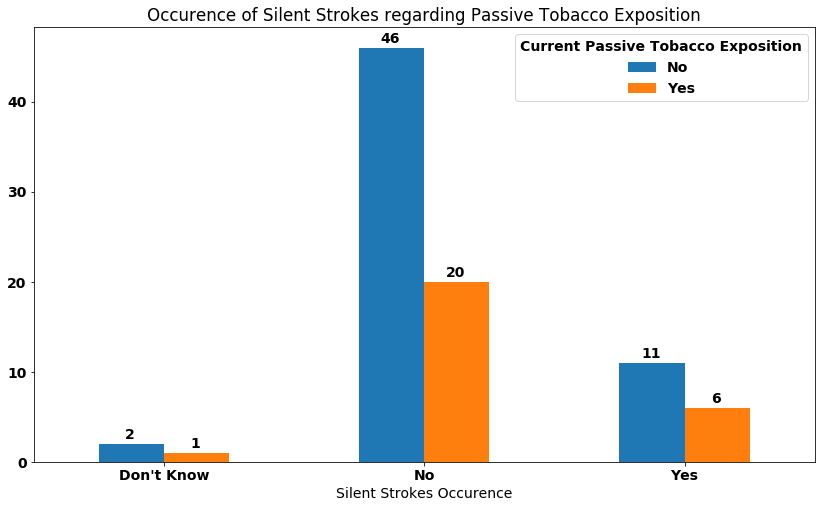

In [26]:
fig = query_df\
.rename({smoke_varname: "Current Passive Tobacco Exposition", 
         stroke_varname: "Silent Strokes Occurence"}, axis=1)\
.groupby("Current Passive Tobacco Exposition")["Silent Strokes Occurence"]\
.value_counts().unstack(0).plot.bar(rot=0)
fig.set_title("Occurence of Silent Strokes regarding Passive Tobacco Exposition")
for p in fig.patches:
    fig.annotate(str(p.get_height()),
                 (p.get_x() + 0.12, p.get_height() + 1),
                va="center",
                ha="center")